In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from scipy import stats as st

import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

from fit_and_print import fit_model_and_print_metrics
from sklearn.model_selection import StratifiedKFold # preserves the ratio of the KFolds (341:242), helps to prevent overfitting
#from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier 
    
from sklearn.svm import SVC

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_style("darkgrid")
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data Exploration

In [2]:
train_variants_df = pd.read_csv("msk-redefining-cancer-treatment/training_variants", index_col = 0)
test_variants_df = pd.read_csv("msk-redefining-cancer-treatment/test_variants", header = None, names = train_variants_df.columns, index_col = 0)
train_text_df = pd.read_csv("msk-redefining-cancer-treatment/training_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"], index_col = 0)
test_text_df = pd.read_csv("msk-redefining-cancer-treatment/test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"], index_col = 0)

In [3]:
# train_variants_df.head(30)
# train_variants_df.Class.value_counts()


In [4]:
train_variants_df = train_variants_df.merge(train_text_df, left_index = True, right_index = True)
test_variants_df = test_variants_df.merge(test_text_df, left_index = True, right_index = True)
train_variants_df.head()

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [17]:
from nltk import regexp_tokenize
from nltk.stem import *
from nltk.corpus import stopwords


def clean_text(text):
    #choose non punctuated letters
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens = regexp_tokenize(text, pattern) 
    
    #makes all words lower case
    tokens = [token.lower() for token in tokens]
    #if words not in basically a list of common words in English, then include it in a list called tokens
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    #take the morphological endings off the words to leave a 'stem', that ways words like 'cake' and 'cakes' will both be counted as instances of 'cake'
    p_stemmer = PorterStemmer()
    tokens = [p_stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

In [5]:
def search_df_subset(df):
    classes = df.Class.unique()
    class_word_list = []
    for c in range(len(classes)):
        df_subset = df[df['Class'] == c+1]
        text_dict = {}
        for i in range(len(df_subset)):
            to_read = df_subset.iloc[i,3]
            try:
                to_read = to_read.split()
                for word in to_read:
                    if len(word) >= 4:
                        if word in text_dict:
                            text_dict[word] += 1
                        else:
                            text_dict[word] = 1
            except:
                continue
        ordered_dict = sorted(list(text_dict.items()), key = lambda x: x[1], reverse = True)
        class_word_list.append(ordered_dict)
    return class_word_list

In [6]:
words_list = search_df_subset(train_variants_df)

In [10]:
def find_unique_sets(words_list):
    sets = []
    for words in words_list:
        sets.append(set([x[0] for x in words]))
    unique_sets = []
    for i in range(len(sets)):
        sets_mod = [x for x in sets]
        target = sets_mod.pop(i)
        u = set.union(*sets_mod)
        unique_sets.append(target.difference(u))
    return unique_sets

In [11]:
unique_sets = find_unique_sets(words_list)

In [12]:
def get_top_words(number, df):
    classes = df.Class.unique()
    class_word_list = []
    for c in range(len(classes)):
        df_subset = df[df['Class'] == c+1]
        class_words = unique_sets[c]
        text_dict = {}
        for i in range(len(df_subset)):
            to_read = df_subset.iloc[i,3]
            try:
                to_read = to_read.split()
                for word in to_read:
                    if word in class_words:
                        if word in text_dict:
                            text_dict[word] += 1
                        else:
                            text_dict[word] = 1
            except:
                continue
        ordered_dict = sorted(list(text_dict.items()), key = lambda x: x[1], reverse = True)[:number]
        class_word_list.append(ordered_dict)
    return class_word_list

In [13]:
top_words = get_top_words(1000, train_variants_df)

In [15]:
top_words_total = []
for word_list in top_words:
    for word in word_list:
        top_words_total.append(word[0])
        
top_words_total[:10]

['DCAF1',
 'IFITM1',
 'Asxl1',
 'CRL4DCAF1',
 'PTPμ',
 'FNIII',
 'hook',
 'Ser217',
 'TNRC6B',
 'AGO2']

In [25]:
# grouped = train_variants_df.groupby('Gene').size().sort_values(ascending = False).iloc[:50]
# grouped.plot(kind = 'bar', figsize = (15,6))


In [26]:
print("Unique Genes: \t\t", len(train_variants_df.Gene.unique()),\
      "\nUnique Variations: \t", len(train_variants_df.Variation.unique()),\
      "\nUnique Classes: \t", len(train_variants_df.Class.unique()),\
      "\nLength of dataframe: \t", len(train_variants_df))


Unique Genes: 		 264 
Unique Variations: 	 2996 
Unique Classes: 	 9 
Length of dataframe: 	 3321


In [27]:
# print(train_variants_df.info(), train_text_df.info())



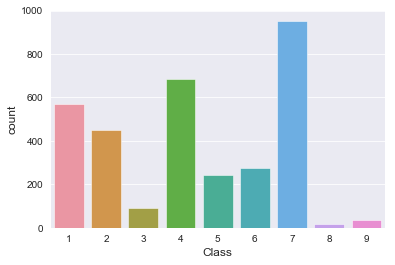

In [28]:
sns.countplot(x = train_variants_df['Class'])



## Extracting Amino Acid Information

In [29]:
train_variants_df.Variation.value_counts()



Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
R130G                    1
F568fs                   1
R139G                    1
N659R                    1
P95S                     1
Name: Variation, Length: 2996, dtype: int64

In [16]:
# Defining Groups of Amino Acids

acidic_polar = {'D': 'Aspartic Acid', 'E': 'Glutamic Acid'}
basic_polar = {'R': 'Arginine', 'H': 'Histidine', 'K': 'Lysine'}
nonpolar = {'A': 'Alanine', 'C': 'Cysteine', 'G': 'Glycine', 'I': 'Isoleucine', 'L': 'Leucine', 'M': 'Methionine',\
           'F': 'Phenylalanine', 'P': 'Proline', 'W': 'Tryptophan', 'V': 'Valine'}
polar = {'N': 'Asparagine', 'Q': 'Glutamine', 'S': 'Serine', 'T': 'Threonine', 'Y': 'Tyrosine'}

amino_acids = [acidic_polar, basic_polar, nonpolar, polar]

In [17]:
def get_mutation_type(variation):
    if 'Truncating Mutations' in variation or 'trunc' in variation:
        mutation = 'Nonsense'
    elif 'delins' in variation.lower():
        mutation = 'Deletion/Insertion'
    elif 'ins' in variation.lower():
        mutation = 'Insertion'
    elif 'fs' in variation.lower():
        mutation = 'Frameshift'
    elif 'del' in variation.lower():
        mutation = 'Deletion'
    elif 'dup' in variation.lower():
        mutation = 'Duplication'
    elif 'splice' in variation.lower():
        mutation = 'Splice'
    elif (variation == 'Deletion') or (variation == 'Amplification') or (variation == 'Fusions') or (variation == 'Overexpression'):
        mutation = variation
    elif '*' in variation.lower():
            mutation = 'Nonsense'
    elif len(variation) <= 6:
        mutation = 'Non-Conservative Missense'
        #mutation = variation[0] #+ variation[-1]
        for amino_acid in amino_acids:
            if (variation[0] in amino_acid) and (variation[-1] in amino_acid):
                mutation = 'Conservative Missense'
    elif 'Fusion' in variation:
        mutation = 'Fusions'
    elif 'prom' in variation.lower():
        mutation = 'Promoter'
    else:
        mutation = 'Other'
    return mutation

In [32]:
# def get_distance(variation):
#     if len(variation) <= 6:
#         distance = variation[1:-1]
#         try:
#             distance = int(distance)
#         except:
#             distance = np.nan      
#     elif 'prom' in variation.lower():
#         distance = 0
#     else:
#         distance = np.nan
#     return distance
        

In [33]:
# def get_distance_bucket(distance):
#     if distance <= 50:
#         bucket = 'Beginning'
#     elif distance <= 150:
#         bucket = 'Near Beginning'
#     elif distance <= 200:
#         bucket = 'Early'
#     elif distance > 200:
#         bucket = 'Not Beginning'
#     else:
#         bucket = np.nan
#     return bucket

In [34]:
# def get_distance_bucket_standard(variation):
#     distance = get_distance(variation)
#     mutation_type = get_mutation_type(variation)
    

In [18]:
def is_word_in(string):
    try:
        words = string.split()
        words = set(words)
        matched_words = []
        for word in words:
            if word in top_words_total:
                matched_words.append(word)
        matched_words = list(set(matched_words))
    except:
        matched_words = None
    return matched_words


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

train_variants_df['Label'] = 'Train'
test_variants_df['Label'] = 'Test'


concat_df = pd.concat([train_variants_df , test_variants_df])
concat_df['Text'] = concat_df['Text'].fillna('None')
# concat_df['Text'] = concat_df['Text'].apply(clean_text)

# cv = CountVectorizer()
# cv.fit(concat_df['Text'])
# concat_df = concat_df.merge(pd.DataFrame(cv.transform(concat_df['Text']).toarray()), left_index = True, right_index = True)

concat_df['Mutation Type'] = concat_df.Variation.apply(get_mutation_type)
concat_df = concat_df[concat_df['Mutation Type'] != 'Other']
concat_df.reset_index(inplace = True, drop = True)


In [ ]:
concat_df.head()
# concat_df['Text_Transformed'][0]

In [37]:
6000*3000

18000000

In [ ]:
#matched_df = concat_df.Matched_Words.str.join('|').str.get_dummies().add_prefix('word_')

In [ ]:
#len(matched_df)

In [ ]:
#concat_df = concat_df.merge(matched_df, left_index = True, right_index = True)

In [ ]:
#concat_df = concat_df.drop(columns = ['index'])

In [ ]:
#concat_df.head()

In [20]:
concat_df = pd.get_dummies(concat_df, columns = ['Gene', 'Mutation Type'])


In [ ]:
concat_df.shape

In [21]:
train_variants_df = concat_df[concat_df['Label'] == 'Train']
test_variants_df = concat_df[concat_df['Label'] == 'Test']

### Preparing final df for analysis

In [ ]:
train_variants_df.head()

In [22]:
y = train_variants_df.Class
X = train_variants_df.drop(columns = ['Variation', 'Class', 'Text', 'Label'])
y_test = test_variants_df.Class
X_test = test_variants_df.drop(columns = ['Variation', 'Class', 'Text', 'Label'])



In [ ]:
X.head()

In [ ]:
# def scale_features(X):
#     ss = skp.StandardScaler()
#     for feature in list(X):
#         X[feature] = ss.fit_transform(X[[feature]]) # don't forget the double bracket
#     return X

# scale_features(X)

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

mnb = MultinomialNB()
mnb.fit(X, y)
mnb.score(X_test, y_test)
##mnb.predict(cv.transform(X_test))
#confusion_matrix(y_test, X_test)

0.5846994535519126

In [25]:
rf = RandomForestClassifier(n_estimators= 50, criterion = 'gini')
stk = StratifiedKFold(n_splits = 10)
model = fit_model_and_print_metrics(list(stk.split(X, y)), X, y, rf, print_metrics = True)


accuracy_score: 0.3278078410190875
precision_score: 0.3254164754448179
recall_score: 0.3278078410190875
f1_score: 0.2964415501200617


In [24]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X, y)
bnb.score(X_test, y_test)

0.5901639344262295

In [ ]:
# svc = SVC(kernel = 'rbf', probability = True)
# results = fit_model_and_print_metrics(list(stk.split(X, y)), X, y, svc, print_metrics = True)


In [26]:
predicted = rf.predict(X_test)
#predicted = svc.predict(X_test)


In [27]:
test_results = test_variants_df
test_results['Predicted'] = predicted
test_results['Correct'] = np.where(test_results['Predicted'] == test_results['Class'], True, False)


In [28]:
test_results

,Variation,Class,Text,Label,Gene_ABL1,Gene_ACVR1,Gene_AGO2,Gene_AKT1,Gene_AKT2,Gene_AKT3,...,Mutation Type_Frameshift,Mutation Type_Fusions,Mutation Type_Insertion,Mutation Type_Non-Conservative Missense,Mutation Type_Nonsense,Mutation Type_Overexpression,Mutation Type_Promoter,Mutation Type_Splice,Predicted,Correct
3304,S80N,6,Abstract Background Non-small cell lung canc...,Test,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,False
3305,M173I,4,Rasopathies are phenotypically similar syndrom...,Test,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,True
3306,D1709N,4,Abstract DICER1 plays a critical role in mic...,Test,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,4,True
3307,S492F,1,The receptor protein tyrosine phosphatase T (P...,Test,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,True
3308,Truncating Mutations,1,"Tyrosine phosphorylation, regulated by protein...",Test,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,True
3309,Q479E,1,The receptor protein tyrosine phosphatase T (P...,Test,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,True
3310,Truncating Mutations,1,"Mre11, Rad50, and Nbs1 function in a protein c...",Test,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,True
3311,D286_L292trunc,2,The activities of cyclin D-dependent kinases s...,Test,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,7,False
3312,Truncating Mutations,1,The TGF-βs are a family of ligands that potent...,Test,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,4,False
3313,E526Q,4,Transforming growth factor β (TGFβ) plays a ke...,Test,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,4,True


In [29]:
test_results[['Class', 'Predicted', 'Correct']]


,Class,Predicted,Correct
3304,6,4,False
3305,4,4,True
3306,4,4,True
3307,1,1,True
3308,1,1,True
3309,1,1,True
3310,1,1,True
3311,2,7,False
3312,1,4,False
3313,4,4,True


In [30]:
len(test_results[test_results['Correct']])/len(test_results)



0.5956284153005464